# 5. Support Vector Machines

*Support Vector Machines (SVMs)* can perform linear/non-linear classification, regression, and outlier detection. They are particularly effective for classification of small-medium datasets.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

## Linear SVM Classification

**Large Margin Classification**
- Two classes (in $n$ dimensions) are *linearly separable*if there exists a straight line ($n-1$-dimensional affine hyperplane) separating them
- Imagine two equidistant parallel lines (hyperplanes) at distance $d$ on either side of the separating line (hyperplane); we call these the *marginns*
- An SVM classifier doing *large margin classification* finds the separating line (hyperplane) with maximum $d$ such that there are no training samples between the margins
- Note that the separating plane is determined by the points that intersect the margins - called *support vectors*
- The separating $n-1$-dimensional hyperplane is the intersection $h(\mathbf{x})=0$ of an $n$-dimensional hyperplane with the feature space and the margins are the hyperplanes $h(\mathbf{x})=\pm 1$
- SVMs are very sensitive to the scales of the features, so you must always use feature scaling
- Large margin only works if the data is linearly separable and even then is very sensitive to outliers

**Soft Margin Classification:** seeks to maximise the distance between margins while limiting (but not necessarily eliminating) *margin violations* (where an instance is on the wrong side of a margin)
- The hyperparameter $C>0$ controls how harshly margin violations are penalised, so smaller $C$ means more regularisation ($C\to\infty$ leads to large margin classification
- SVM classifiers do *not* generate class probabilities, just a prediction
- There are 3 options for linear SVM classifiers: in Scikit-Learn:
    - `LinearSVC`: specialised for linear SVM classifier and is particularly efficient
    - `SVC(kernel="linear")`: general SVM classifier - still scales well with features
    - `SGDClassifier(loss="hinge", alpha=1/(m*C))`: linear SVM classifier via stochastic gradient descent - doesn't converge as fast but allows out-of-core learning

In [2]:
from sklearn import datasets
from sklearn.utils import shuffle

# import iris sample data
iris = datasets.load_iris()

X = pd.DataFrame(data=iris["data"], columns=iris["feature_names"])
y = iris["target"]

# shuffle since data is ordered by class
X, y = shuffle(X, y)

# restrict to binary problem and 2 features
X_petal = X[
    ["petal length (cm)", "petal width (cm)"]
]
y_virg = (y == 2).astype(int)

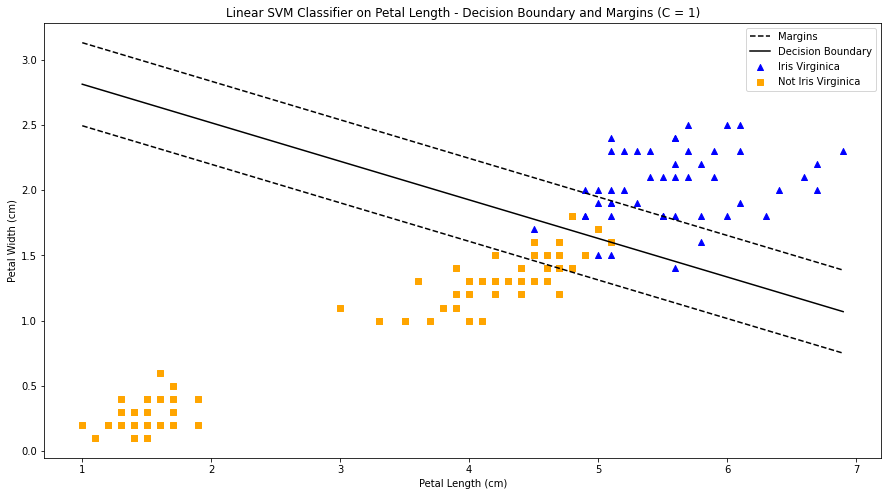

In [3]:
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

pipe = make_pipeline(StandardScaler(), LinearSVC(C=1, loss="hinge"))
pipe.fit(X_petal, y_virg)

def plot_decision_boundary():
    fig, ax = plt.subplots(figsize=(15, 8))

    def solve_linear_equation(intercept, coef, x, b=0):
        "Solve equation of the form intercept + coef[0]*x + coef[1]*y=b for y"
        y = b - coef[0] * x - intercept
        y /= coef[1]

        return y

    
    scaler = pipe[0]
    lin_svc = pipe[1]
    
    # decision function from SVM
    intercept = lin_svc.intercept_[0]
    coef = lin_svc.coef_[0]
    
    # want to plot intercept + coef[0]*x + coef[1]*y=b for b =-1, 0, 1
    # need to scale x_plot, solve equation for y, then unscale y
    x_plot = np.linspace(
        X_petal["petal length (cm)"].min(), X_petal["petal length (cm)"].max(), 100
    )
    x_plot_scaled = scaler.transform(
        np.c_[x_plot, np.zeros(len(x_plot))] # scaler required array size (*,2) so add a dummy col
    )[:, 0]
    
    for ix, b in enumerate([-1, 0, 1]):
        y_plot_scaled = solve_linear_equation(
            intercept,
            coef,
            x_plot_scaled,
            b
        )
        y_plot = scaler.inverse_transform(
            np.c_[np.zeros(len(y_plot_scaled)), y_plot_scaled]
        )[:, 1]
        
        if b == 0:
            ax.plot(x_plot, y_plot, color="k", ls="-", label="Decision Boundary")
        elif ix == 0:
            ax.plot(x_plot, y_plot, color="k", ls="--", label="Margins")
        else:
            ax.plot(x_plot, y_plot, color="k", ls="--")

    # data points
    ax.scatter(
        X_petal.loc[y_virg == 1, "petal length (cm)"],
        X_petal.loc[y_virg == 1, "petal width (cm)"],
        marker="^",
        color="blue",
        label="Iris Virginica",
    )
    ax.scatter(
        X_petal.loc[y_virg == 0, "petal length (cm)"],
        X_petal.loc[y_virg == 0, "petal width (cm)"],
        marker="s",
        color="orange",
        label="Not Iris Virginica",
    )

    ax.set_xlabel("Petal Length (cm)")
    ax.set_ylabel("Petal Width (cm)")

    ax.set_title("Linear SVM Classifier on Petal Length - Decision Boundary and Margins (C = {})".format(lin_svc.get_params()["C"]))

    ax.legend()


plot_decision_boundary()

## Nonlinear SVM Classification

**Polynomial Kernel:** 
- When the data isn't even close to being linearly separable you can try adding additional (e.g. polynomial) features to transform into a linearly separable space
- Using a *polynomial kernel* is equivalent to adding polynomial features, but doesn't have the downsides of the increase in features (because you don't actually add them)
- This adds 2 extra hyperparameters: `degree` (highest degree polynomials) and `coef0` - a constant in the kernel that determines the impact of high-degree polynomials vs low-degree

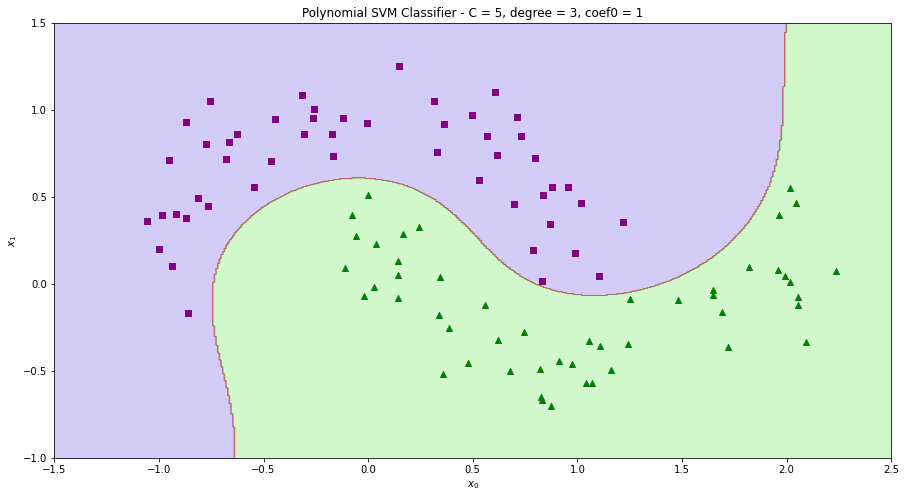

In [4]:
from sklearn.datasets import make_moons
from sklearn.svm import SVC
from sklearn.base import clone

# generate sample data - 2 interleaving half circles
X, y = make_moons(n_samples=100, noise=0.15)

poly_svc = make_pipeline(StandardScaler(), SVC(kernel="poly", degree=3, coef0=1, C=5))
poly_svc.fit(X, y)

def plot_class_predictions(clf, xlim, ylim):
    # generate values along each axis
    x0s = np.linspace(xlim[0], xlim[1], 500)
    x1s = np.linspace(ylim[0], ylim[1], 500)
    
    # all combinations of (x0, x1) for plot
    x0, x1 = np.meshgrid(x0s, x1s)

    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)

    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)


def plot_binary_data(X, y):
    plt.scatter(
        X[:, 0][y == 1],
        X[:, 1][y == 1],
        marker="^",
        color="green",
    )
    plt.scatter(
        X[:, 0][y == 0],
        X[:, 1][y == 0],
        marker="s",
        color="purple",
    )


xlim = np.array([-1.5, 2.5])
ylim = np.array([-1, 1.5])

fig, ax = plt.subplots(figsize=(15, 8))

plot_class_predictions(poly_svc, xlim, ylim)
plot_binary_data(X, y)

ax.set_xlabel("$x_0$")
ax.set_ylabel("$x_1$")

ax.set_title("Polynomial SVM Classifier - C = {}, degree = {}, coef0 = {}".format(
    poly_svc["svc"].get_params()["C"],
    poly_svc["svc"].get_params()["degree"],
    poly_svc["svc"].get_params()["coef0"]
));

**Similarity Features:** you can also add features by using a *similarity function* to measure resemblence to a particular *landmark*
- E.g. pick a landmark point $l$ and define a new feature whose value at instance $\mathbf{x}$ is given by  computign the Gaussian *Radial Basis Function* (RBF) for some value of $\gamma$:

\begin{equation}
    \phi_{\gamma}(\mathbf{x}, l) = \exp\left(-\gamma\lVert \mathbf{x}-l\rVert^2\right)
\end{equation}

- $\gamma$ acts as a hyperparameter - decreasign it makes the bell curve around $l$ smoother, so increases regularisation
- The simplest choice of landmark points are just the training points, but this means the same number of features as training points - again we resolve this using kernels

**Gaussian RBF Kernel:** equivalent to adding landmarks at each training point with Gaussian RBF similarity function, but much more computationally efficient
- 2 hyperparameters $\gamma$ and $C$ - decreasing either increases regularisation
- The hyperparameters can take quite a wide range - it's good to do an initial grid search with them taking a wide range of values
- There are other kernels but they're less common
- As a rule of thumb, always use a linear kernel first (particularly if the training set is large). If training set isn't too large, then Gaussian RBF is also often effective

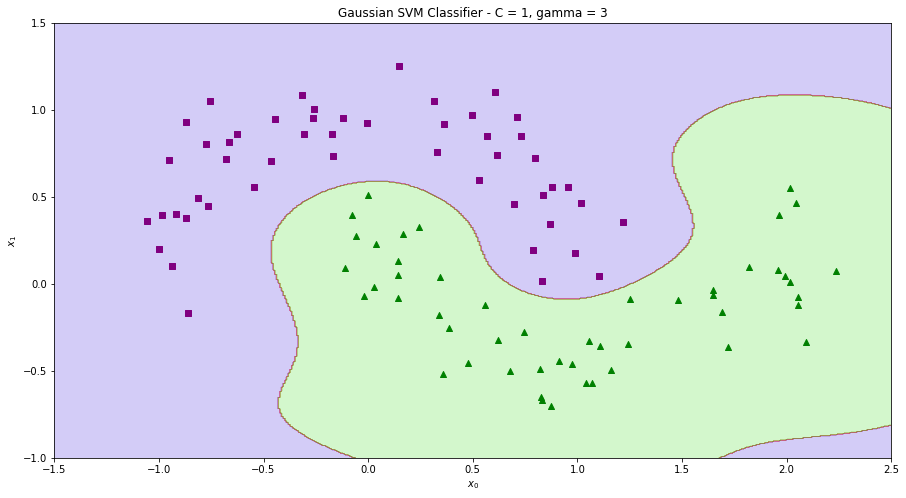

In [5]:
# gaussian rbf kernel on moons data
gauss_svc = make_pipeline(StandardScaler(), SVC(kernel="rbf", gamma=3, C=1))
gauss_svc.fit(X, y)

xlim = np.array([-1.5, 2.5])
ylim = np.array([-1, 1.5])

fig, ax = plt.subplots(figsize=(15, 8))

plot_class_predictions(gauss_svc, xlim, ylim)
plot_binary_data(X, y)

ax.set_xlabel("$x_0$")
ax.set_ylabel("$x_1$")

ax.set_title("Gaussian SVM Classifier - C = {}, gamma = {}".format(
    gauss_svc["svc"].get_params()["C"],
    gauss_svc["svc"].get_params()["gamma"],
));

**Multi-class Classification**
- `SVC` uses OvO multiclass classification as default as it doesn't scale well with the training set
- `LinearSVC` uses OvM as default

**Computational Complexity**
- `LinearSVC` scales almost linearly with numbers of features and training instances
- `SVC` supports the kernel trick, but it scales between quadratic and cubic for training instances so isn't practical for large datasets (100,000s)
- `SVC` works well for small-ish  training sets and large numbers of (particularly *sparse*) features

| Class | Time complexity | Out-of-score support | Scaling required | Kernel trick |
|---|---|---|---|---|
| `LinearSVC` | $O(m\times n)$ | No | Yes | No |
| `SGDClassifier` | $O(m\times n)$ | Yes | Yes | No |
| `SVC` | $O(m^2\times n)$ to $O(m^2\times n)$ | No | Yes | Yes |


## SVM Regression

- SVMs can also be used for regression - the algorithm seeks to minimise the number of samples outside the margins, where the distance to the margins is set as a *threshold* hyperparameter $\varepsilon$
- The model is *$\varepsilon$-insensitive* - adding more instances inside the margins doesn't change the model
- As with classification, the data must be scaled and centred
- Essentially everything said for SVM classification also holds for regression

Intercept: 7.38
Coefficient: 1.80


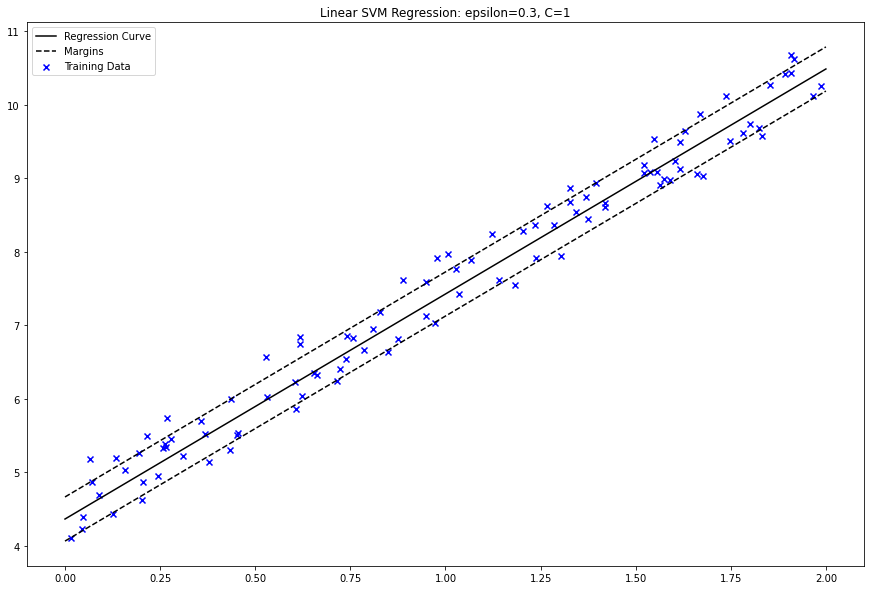

In [12]:
# linear SVR
from sklearn.svm import LinearSVR

# generate some sample data
X = 2 * np.random.rand(100, 1)  # sampled from [0,1) with shape (100, 1)
y = 4 + 3 * X + np.random.rand(100, 1)

# fit model
pipe = make_pipeline(
    StandardScaler(),
    LinearSVR(epsilon=0.3, C=1)
)
pipe.fit(X, y.ravel())

lin_svr = pipe["linearsvr"]
print("Intercept: {:.2f}".format(lin_svr.intercept_[0]))
print("Coefficient: {:.2f}".format(lin_svr.coef_[0]))

# generate data to plot curve
x0 = np.linspace(0, 2, 101)
x0 = np.c_[x0]  # predict expects shape (m, 1), not (m)
y_pred = pipe.predict(x0)

# plot curve against training data
fig, ax = plt.subplots(figsize=(15, 10))

ax.scatter(X, y, color="blue", marker="x", label="Training Data")
ax.plot(x0, y_pred, ls="-", color="k", label="Regression Curve")

# plot margins
epsilon = lin_svr.get_params()["epsilon"]
ax.plot(x0, y_pred + epsilon, ls="--", color="k", label="Margins")
ax.plot(x0, y_pred - epsilon, ls="--", color="k")

ax.set_title("Linear SVM Regression: epsilon={}, C={}".format(epsilon, lin_svr.get_params()["C"]))

ax.legend();

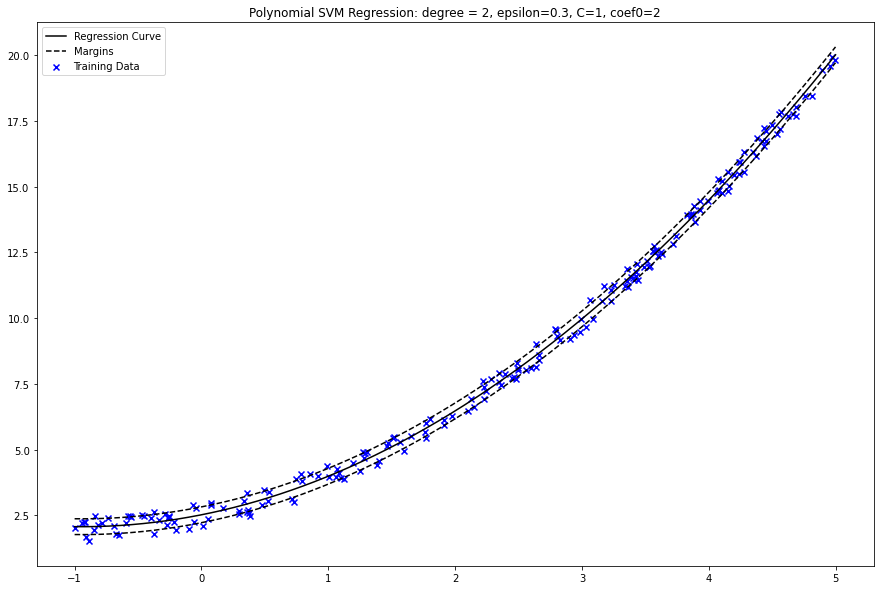

In [25]:
# SVR with polynomial kernel
from sklearn.svm import SVR

# generate some sample data
n_samples = 200
X = 6 * np.random.rand(n_samples, 1) - 1
y = 0.5 * X**2 + X + 2 + np.random.rand(n_samples, 1)

# fit model
pipe = make_pipeline(
    StandardScaler(), 
    SVR(kernel="poly", degree=2, C=1, epsilon=.3, coef0=2) # for some reason this is terrible if coef0=0
)
pipe.fit(X, y.ravel())

# generate data
x0 = np.linspace(-1, 5, 601)
x0 = np.c_[x0]  # predict expects shape (m, 1), not (m)

y_pred = pipe.predict(x0)

# plot curves against training data
fig, ax = plt.subplots(figsize=(15, 10))

ax.scatter(X, y, color="blue", marker="x", label="Training Data")
ax.plot(x0, y_pred, ls="-", color="k", label="Regression Curve")

# plot margins
poly_svr = pipe["svr"]
epsilon = poly_svr.get_params()["epsilon"]
ax.plot(x0, y_pred + epsilon, ls="--", color="k", label="Margins")
ax.plot(x0, y_pred - epsilon, ls="--", color="k")

ax.set_title("Polynomial SVM Regression: degree = {}, epsilon={}, C={}, coef0={}".format(
    poly_svr.get_params()["degree"], epsilon, poly_svr.get_params()["C"], poly_svr.get_params()["coef0"])
)

ax.legend();